### Minh Vo
### ADSP 32018 - Natural Language Processing and Cognitive Computing (Autumn 23)
### FINAL PROJECT

### Topic Detection

In [1]:
# !pip install gensim
# !pip install pyLDAvis

In [1]:
import time
import math
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from google.cloud import storage
import os

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import spacy
from spacy import displacy

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('once')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [2]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 96


In [3]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)
workers=num_processors

INFO: Pandarallel will run on 95 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Cleaned Data Loading

In [4]:
%%time

cleaned_news_df = pd.read_parquet('final_cleaned_news_df.parquet', engine = 'pyarrow')

print(f'Cleaned data contains {cleaned_news_df.shape[0]:,.0f} news articles')
cleaned_news_df.head(2)

Cleaned data contains 191,487 news articles
CPU times: user 9.23 s, sys: 7.07 s, total: 16.3 s
Wall time: 11.7 s


,url,date,language,title,text,cleaned_title,cleaned_text,text_word_count,lemmatized_title,lemmatized_text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,666,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,587,observation simulation ai join force reveal clear universe spaceref,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical japanese astronomer develop new artificial intelligence ai technique remove noise astronomical datum due ...


In [5]:
cleaned_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191487 entries, 0 to 199676
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   url               191487 non-null  object
 1   date              191487 non-null  object
 2   language          191487 non-null  object
 3   title             191487 non-null  object
 4   text              191487 non-null  object
 5   cleaned_title     191487 non-null  object
 6   cleaned_text      191487 non-null  object
 7   text_word_count   191487 non-null  int64 
 8   lemmatized_title  191487 non-null  object
 9   lemmatized_text   191487 non-null  object
dtypes: int64(1), object(9)
memory usage: 16.1+ MB


#### Topic Modeling - SAMPLE DATA

In [7]:
sample_df = cleaned_news_df.sample(n = 10000, random_state = 42)
sample_df.shape

(10000, 10)

In [8]:
# sample_df.to_parquet('cleaned_sample_df.parquet')

##### Tokenize news title & text

In [8]:
%%time
        
sample_df['lemma_title_tokens'] = sample_df['lemmatized_title'].parallel_apply(lambda x: nltk.word_tokenize(x))
sample_df['lemma_text_tokens'] = sample_df['lemmatized_text'].parallel_apply(lambda x: nltk.word_tokenize(x))

CPU times: user 1.15 s, sys: 13.2 s, total: 14.4 s
Wall time: 15.1 s


In [9]:
sample_df[['cleaned_title', 'lemmatized_title', 'lemma_title_tokens']].sample(n = 3, random_state = 42)

,cleaned_title,lemmatized_title,lemma_title_tokens
127451,innovative eyewear inc announces release chatgpt app smart eyewear,innovative announce release smart eyewear,"[innovative, announce, release, smart, eyewear]"
121872,owns spongebob ai shakes hollywoods creative foundation wsj,own shake hollywood creative foundation wsj,"[own, shake, hollywood, creative, foundation, wsj]"
38625,auc data science initiative partners mastercard drive impact data science,auc datum science initiative partner mastercard drive impact datum science,"[auc, datum, science, initiative, partner, mastercard, drive, impact, datum, science]"


In [10]:
sample_df[['cleaned_text', 'lemmatized_text', 'lemma_text_tokens']].sample(n = 3, random_state = 42)

,cleaned_text,lemmatized_text,lemma_text_tokens
127451,innovative eyewear inc announces release chatgpt app smart eyewear answersyokem ussummer heat safety tipswatch livelatest votecrimeback schoolmind matterssubmit news appwatch livewatch roku amazon firegetting answers photos videosmeet ends meetnews nowgetting votegreat health good stuffkeeping weather weather coveragefirst alert weather safety guidenews salutessenior focussubmit showyour voicequeen school country music dc bureaupress releases weather alerts effectdismiss weather alerts alert...,innovative announce release smart eyewear heat safety tipswatch livelat votecrimeback schoolmind matterssubmit news appwatch livewatch roku amazon firegette answer photo videosmeet end votegreat health good stuffkeepe weather weather alert weather safety guidenew focussubmit showyour voicequeen school country music bureaupress release weather alert effectdismiss weather alert alert barinnovative announce release cdtupdate innovative innovative eyewear company excite announce major update com...,"[innovative, announce, release, smart, eyewear, heat, safety, tipswatch, livelat, votecrimeback, schoolmind, matterssubmit, news, appwatch, livewatch, roku, amazon, firegette, answer, photo, videosmeet, end, votegreat, health, good, stuffkeepe, weather, weather, alert, weather, safety, guidenew, focussubmit, showyour, voicequeen, school, country, music, bureaupress, release, weather, alert, effectdismiss, weather, alert, alert, barinnovative, announce, release, cdtupdate, innovative, innovat..."
121872,owns spongebob ai shakes hollywoods creative foundation wsjskip main copy personal noncommercial use distribution use material governed subscriber agreement law nonpersonal use order multiple copies please contact dow jones reprints visit margaret owns spongebob ai shakes hollywoods creative tools raise questions rights scrutiny courts entertainment executivesby jessica toonkel sarah krouseapril etlisten article minuteswhen paramount globals technology chief phil wiser previewed company lead...,own shake hollywood creative foundation wsjskip main copy personal noncommercial use distribution use material govern subscriber agreement law nonpersonal use order multiple copy contact visit own shake hollywood creative tool raise question right scrutiny court article technology chief preview company leader risk wonder artificial intelligence turn spongebob squarepantsmr wise instruct tool call dalle show spongebob paramount iconic character fly plane image rectangular star appear large tv...,"[own, shake, hollywood, creative, foundation, wsjskip, main, copy, personal, noncommercial, use, distribution, use, material, govern, subscriber, agreement, law, nonpersonal, use, order, multiple, copy, contact, visit, own, shake, hollywood, creative, tool, raise, question, right, scrutiny, court, article, technology, chief, preview, company, leader, risk, wonder, artificial, intelligence, turn, spongebob, squarepantsmr, wise, instruct, tool, call, dalle, show, spongebob, paramount, iconic, ..."
38625,auc data science initiative partners mastercard drive impact data science contentyour money carlson side first alert weathersend ustvhomeget news inboxwatch livesend cw richmondstay got hereadvertise money carlson first alert weatherfirst alert weather blog delaysallergy reportdress mental healthon sideacts better mental healthrva wallet towncommunity pet moviesabout usnextgen tvcontact usmeet teamnbc viewpointnbc jobstvwatch livecircle country music dc bureausponsor releasesthe auc data sci...,auc datum science initiative partner mastercard drive impact datum science money carlson side first alert weathersend livesend cw richmondstay get hereadvertise money carlson alert weatherfirst alert weather blog delaysallergy sideact well mental wallet moviesabout usnextgen tvcontact bureausponsor datum science initiative partner mastercard drive impact datum oct edtupdate minute agothrough support expansion datum science e

Because news title

##### Creating Dictionary and Corpus

In [11]:
# Get the list of lemmatizeed text tokens
lemma_text_tokens_list = sample_df['lemma_text_tokens'].tolist()

In [12]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(lemma_text_tokens_list)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in lemma_text_tokens_list]

CPU times: user 9.66 s, sys: 596 ms, total: 10.3 s
Wall time: 10.3 s


##### Building the Initial LDA Model - 10 topics

In [13]:
%%time

lda_model_text = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=num_processors-1)

CPU times: user 1min 50s, sys: 1min 7s, total: 2min 58s
Wall time: 1min 34s


In [14]:
# Print the Keyword in the 10 topics
print(lda_model_text.print_topics())
doc_lda = lda_model_text[doc_term_matrix]

[(0, '0.011*"new" + 0.010*"ai" + 0.008*"use" + 0.007*"news" + 0.006*"good" + 0.005*"open" + 0.005*"get" + 0.004*"review" + 0.004*"game" + 0.004*"tech"'), (1, '0.015*"stock" + 0.008*"company" + 0.007*"ai" + 0.007*"market" + 0.006*"news" + 0.006*"business" + 0.006*"say" + 0.004*"good" + 0.004*"program" + 0.004*"technology"'), (2, '0.014*"ai" + 0.011*"say" + 0.009*"use" + 0.006*"new" + 0.005*"make" + 0.005*"technology" + 0.005*"news" + 0.004*"intelligence" + 0.004*"chatgpt" + 0.004*"get"'), (3, '0.018*"datum" + 0.017*"ai" + 0.009*"use" + 0.008*"learn" + 0.008*"machine" + 0.006*"model" + 0.006*"business" + 0.005*"technology" + 0.005*"customer" + 0.004*"service"'), (4, '0.017*"ago" + 0.012*"hour" + 0.012*"news" + 0.009*"video" + 0.008*"say" + 0.008*"story" + 0.008*"weather" + 0.008*"ai" + 0.006*"day" + 0.006*"sport"'), (5, '0.019*"ai" + 0.010*"technology" + 0.007*"company" + 0.006*"market" + 0.005*"new" + 0.005*"news" + 0.005*"datum" + 0.005*"use" + 0.005*"business" + 0.004*"intelligence"')

In [15]:
%%time

coherence_model_lda_text = CoherenceModel(model=lda_model_text, texts=lemma_text_tokens_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda_text.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39548493872020707
CPU times: user 10.3 s, sys: 11.3 s, total: 21.6 s
Wall time: 22.8 s


##### Tune LDA model

In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=num_processors-1)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemma_text_tokens_list, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [17]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        for a in alpha:
            for b in beta:
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Completed model based on 10 LDA topics. Finished 47.4% of LDA runs
Completed model based on 11 LDA topics. Finished 52.6% of LDA runs
Completed model based on 12 LDA topics. Finished 57.9% of LDA runs
Completed model based on 13 LDA topics. Finished 63.2% of LDA runs
Completed model based on 14 LDA topics. Finished 68.4% of LDA runs
Completed model based on 15 LDA topics. Finished 73.7% of LDA runs
Completed model based on 16 LDA topics. 

In [18]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
4,6,asymmetric,auto,0.422181
11,13,asymmetric,auto,0.418410
6,8,asymmetric,auto,0.415701
10,12,asymmetric,auto,0.414638
7,9,asymmetric,auto,0.408925
5,7,asymmetric,auto,0.407321
16,18,asymmetric,auto,0.405840
14,16,asymmetric,auto,0.404696
13,15,asymmetric,auto,0.404164
12,14,asymmetric,auto,0.404080


<AxesSubplot:xlabel='Topics'>

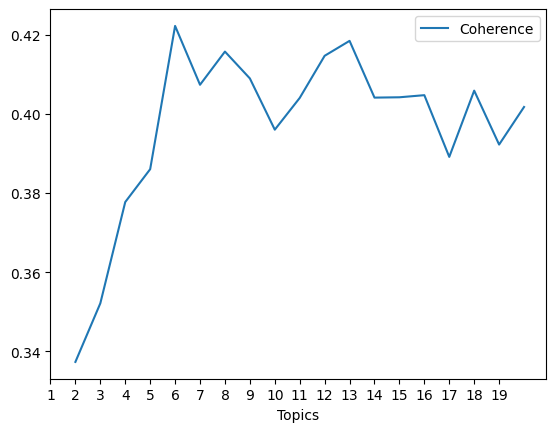

In [19]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

##### Running best model

In [20]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)

tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 6, Alpha: asymmetric, Beta: auto


In [21]:
%%time

tuned_lda_model_text = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = num_processors-1)

print(tuned_lda_model_text.print_topics())

[(0, '0.011*"ai" + 0.011*"use" + 0.008*"new" + 0.005*"datum" + 0.005*"news" + 0.005*"good" + 0.004*"cookie" + 0.004*"business" + 0.004*"user" + 0.004*"get"'), (1, '0.010*"stock" + 0.009*"technology" + 0.009*"service" + 0.008*"business" + 0.008*"news" + 0.008*"product" + 0.007*"ai" + 0.007*"release" + 0.007*"medium" + 0.006*"policy"'), (2, '0.014*"ai" + 0.011*"say" + 0.008*"use" + 0.006*"new" + 0.005*"make" + 0.005*"technology" + 0.004*"news" + 0.004*"company" + 0.004*"intelligence" + 0.004*"get"'), (3, '0.057*"market" + 0.018*"report" + 0.015*"intelligence" + 0.014*"analysis" + 0.014*"artificial" + 0.013*"global" + 0.013*"ai" + 0.012*"growth" + 0.010*"industry" + 0.010*"research"'), (4, '0.014*"ago" + 0.011*"news" + 0.010*"hour" + 0.008*"ai" + 0.008*"video" + 0.007*"say" + 0.007*"story" + 0.006*"weather" + 0.006*"day" + 0.005*"use"'), (5, '0.022*"ai" + 0.009*"technology" + 0.007*"company" + 0.006*"solution" + 0.006*"datum" + 0.006*"provide" + 0.005*"customer" + 0.005*"use" + 0.005*"bus

In [22]:
coherence_tuned_model_lda = CoherenceModel(model=tuned_lda_model_text, texts=lemma_text_tokens_list, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_tuned_model_lda)


Coherence Score:  Coherence_Measure(seg=<function s_one_set at 0x7f14e43c33b0>, prob=<function p_boolean_sliding_window at 0x7f14e43c3a70>, conf=<function cosine_similarity at 0x7f14e431e320>, aggr=<function arithmetic_mean at 0x7f14e431cef0>)


In [30]:
# Parsing the topic words and creating a list of dictionaries
topics_dicts = [{'Topic': topic_num, 'Words': ', '.join(words.split('"')[1::2])} for topic_num, words in topics]

# Creating a DataFrame
topics_df = pd.DataFrame(topics_dicts)

topics_df

,Topic,Words
0,0,"ai, use, new, datum, news, good, cookie, business, user, get, model, make, also, open, say, work, learn, policy, company, technology, feature, privacy, see, information, time"
1,1,"stock, technology, service, business, news, product, ai, release, medium, policy, company, consumer, entertainment, resource, financial, industry, market, health, public, contact, energy, overview, new, electronic, general"
2,2,"ai, say, use, new, make, technology, news, company, intelligence, get, also, artificial, work, chatgpt, year, people, time, day, video, help, world, business, take, go, right"
3,3,"market, report, intelligence, analysis, artificial, global, ai, growth, industry, research, forecast, datum, key, trend, player, business, size, company, application, machine, service, product, learn, top, technology"
4,4,"ago, news, hour, ai, video, say, story, weather, day, use, sport, local, public, get, top, file, new, technology, business, app, report, intelligence, community, company, job"
5,5,"ai, technology, company, solution, datum, provide, customer, use, business, medium, gray, new, release, platform, press, help, group, service, content, learn, say, include, experience, product, industry"


In [28]:
topics = tuned_lda_model_text.print_topics(num_topics=19, num_words=25)

# Process each topic to create a DataFrame
topic_dicts = []

for topic_num, topic_words in topics:
    # Process the string of words to extract individual words
    word_list = [word for word, prob in gensim.models.ldamodel.LdaModel.show_topic(tuned_lda_model_text, topic_num, topn=50)]
    
    # Create a dictionary with topic number and words
    topic_dict = {'Topic': topic_num, 'Words': ', '.join(word_list)}
    
    # Append to the list of topic dictionaries
    topic_dicts.append(topic_dict)

# Create a DataFrame from the list of topic dictionaries
topics_df = pd.DataFrame(topic_dicts)

topics_df

,Topic,Words
0,0,"ai, use, new, datum, news, good, cookie, business, user, get, model, make, also, open, say, work, learn, policy, company, technology, feature, privacy, see, information, time, well, tech, event, content, review, intelligence, help, website, service, artificial, image, product, machine, game, tool, system, follow, contact, create, chatgpt, video, need, app, term, late"
1,1,"stock, technology, service, business, news, product, ai, release, medium, policy, company, consumer, entertainment, resource, financial, industry, market, health, public, contact, energy, overview, new, electronic, general, real, datum, cision, estate, invest, sign, people, use, tech, send, travel, interest, blog, distribution, log, computer, information, culture, rss, sport, intelligence, fund, overviewview, investment, journalist"
2,2,"ai, say, use, new, make, technology, news, company, intelligence, get, also, artificial, work, chatgpt, year, people, time, day, video, help, world, business, take, go, right, tool, tech, see, read, image, privacy, late, story, human, policy, create, model, find, know, write, first, system, need, way, s, come, user, good, show, include"
3,3,"market, report, intelligence, analysis, artificial, global, ai, growth, industry, research, forecast, datum, key, trend, player, business, size, company, application, machine, service, product, learn, top, technology, provide, study, opportunity, revenue, segment, impact, also, region, type, include, development, covid, news, system, use, software, insight, information, demand, future, contact, post, strategy, new, help"
4,4,"ago, news, hour, ai, video, say, story, weather, day, use, sport, local, public, get, top, file, new, technology, business, app, report, intelligence, community, company, job, artificial, year, watch, live, post, right, make, term, update, play, contact, schedule, school, week, work, read, information, alert, close, show, program, people, good, team, help"
5,5,"ai, technology, company, solution, datum, provide, customer, use, business, medium, gray, new, release, platform, press, help, group, service, content, learn, say, include, experience, product, industry, artificial, intelligence, lead, alert, generative, statement, view, team, digital, system, information, model, news, make, health, work, support, enable, world, global, organization, deliver, create, year, well"


In [29]:
topics_df.to_csv('sample_topics_text.csv')

bucket_name = 'minhvo-nlp-final'
file_path = 'sample_topics_text.csv'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)

In [24]:
%%time

lda_display_text = gensimvis.prepare(tuned_lda_model_text, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_text)

CPU times: user 9.84 s, sys: 256 ms, total: 10.1 s
Wall time: 13.6 s
